In [1]:
import cv2
import numpy as np
from scipy.fft import dct
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

In [2]:
def global_noise_var(I):
    # Convert RGB image to grayscale
    I_gray = np.mean(I, axis=-1)
    
    # DCT Transformation
    T = dct(np.identity(8), norm='ortho')
    dct_full = np.block([[dct(dct(I[y:y+8, x:x+8], axis=0, norm='ortho'), axis=1, norm='ortho')
                          for x in range(0, I.shape[1], 8) if x + 8 <= I.shape[1]]
                         for y in range(0, I.shape[0], 8) if y + 8 <= I.shape[0]])

    # Patch Extraction
    dct_patches = dct_full.reshape((8, 8, -1), order='F')
    
    # Statistics Calculation
    kurt_mtx = kurtosis(dct_patches, axis=2)
    var_mtx = np.var(dct_patches, axis=2)
    
    avg_root_kurt = (np.sum(np.sqrt(kurt_mtx)) - np.sqrt(kurt_mtx[0, 0])) / 63
    avg_var_inv_sq = (np.sum(1 / var_mtx**2) - 1 / var_mtx[0, 0]**2) / 63
    avg_root_kurt_var_inv = (np.sum(np.sqrt(kurt_mtx) / var_mtx) - np.sqrt(kurt_mtx[0, 0]) / var_mtx[0, 0]) / 63
    avg_var_inv = (np.sum(1 / var_mtx) - 1 / var_mtx[0, 0]) / 63
    
    root_kurt_conc = ((avg_root_kurt * avg_var_inv_sq) - (avg_root_kurt_var_inv * avg_var_inv)) / (avg_var_inv_sq - avg_var_inv**2)
    
    gnv = 1 / avg_var_inv - avg_root_kurt / (avg_var_inv * root_kurt_conc)
    
    return gnv


In [3]:
def add_gaussian_white_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip values to the valid range [0, 1]

def analyze_gnv_with_noise(original_image, sigmas):
    gnv_values = []
    sigma_sqaured = []

    for sigma in sigmas:
        noisy_image = add_gaussian_white_noise(original_image, sigma)
        gnv = global_noise_var(noisy_image)
        gnv_values.append(gnv)
        sigma_sqaured.append(pow(sigma, 2))

        plt.imshow(noisy_image, cmap='gray')
        plt.title(f'Image with AGNW (Sigma={sigma})')
        plt.show()

        print(f'Global Noise Variance (Sigma={sigma}): {gnv}')

    plt.plot(sigma_sqaured, gnv_values, marker='o')
    plt.xlabel('Sigma squared (Variance of AGNW)')
    plt.ylabel('Global Noise Variance (gnv)')
    plt.title('Effect of AGNW on Global Noise Variance')
    plt.show()

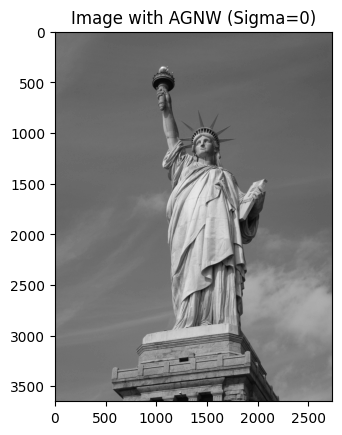

Global Noise Variance (Sigma=0): -2.7861615114236886e-05


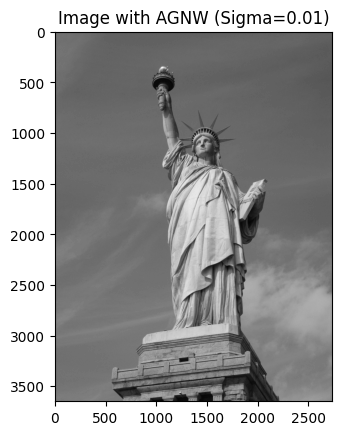

Global Noise Variance (Sigma=0.01): 6.824438738457967e-05


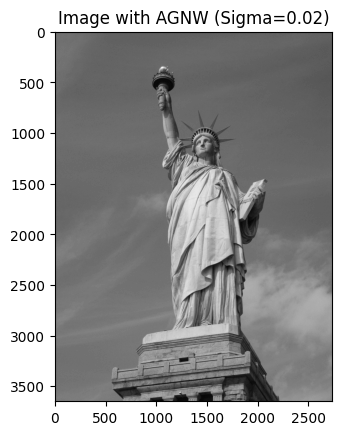

Global Noise Variance (Sigma=0.02): 0.0003233066830297419


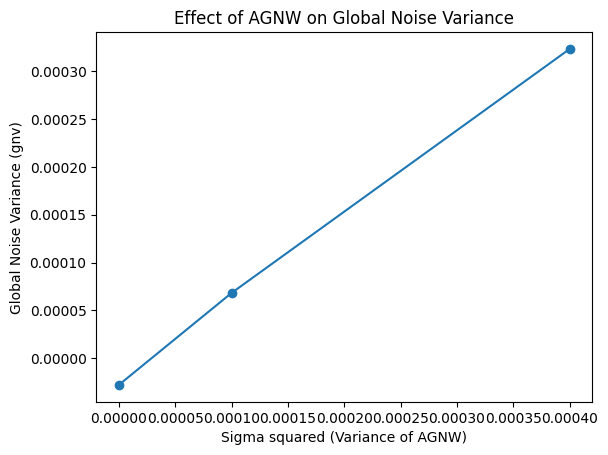

In [6]:
image_path = r"D:\Study Material\SEM 5\CS 663\PROJECT\gnv_test.jpg"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize to [0, 1]

sigma_values = [0, 0.01, 0.02]


analyze_gnv_with_noise(original_image, sigma_values)